In [ ]:
import sys
import os
from tqdm import tqdm
import numpy as np
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, get_peft_model
from datasets import load_dataset, concatenate_datasets
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [14]:
MODEL_NAME = 'HuggingFaceTB/SmolLM-360M'
path = 'output_centralized/experiments_eos2/boolq/360M/checkpoint-100'

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
eos_token_id = tokenizer.eos_token_id

model = PeftModel.from_pretrained(model, path)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [15]:
passage = 'The Post Office provides information on services and accepts postal items and payment on behalf of the two collection and delivery divisions of Royal Mail Group, Royal Mail and Parcelforce. These include a variety of ordinary and guaranteed services both for delivery within the United Kingdom and to international destinations. Postage stamps (including commemorative stamps and other philatelic items) are sold, while applications for redirection of mail are accepted on behalf of Royal Mail.'
question = 'Based on the passage, answer this question: is post office and royal mail the same'

prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{}

### Response: {}{}"""

prompt = prompt.format(passage + ' ' + question, '', '')
inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(model.device)
outputs = model.generate(**inputs, num_return_sequences=1,eos_token_id=eos_token_id)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


In [16]:
inputs['input_ids']

tensor([[19798,   314,   354,  5785,   338,  6601,   253,  3856,    30,  9517,
           253,  2426,   338, 13674, 32873,   260,  3116,    30,   198,   198,
          3757, 20880,    42,   198,   504,  5786,  7054,  2433,  1096,   335,
          2465,   284, 23617, 33014,  3723,   284,  9599,   335, 13369,   282,
           260,   827,  3854,   284,  7037, 14102,   282,  7598, 23767,  6404,
            28,  7598, 23767,   284,   377,  1487,   482, 40653,    30,  1216,
          1453,   253,  3175,   282,  8207,   284, 16524,  2465,  1062,   327,
          7037,  1127,   260,  1797,  8378,   284,   288,  3113, 20274,    30,
          5786,   473, 21487,   365,  8617, 45173, 21487,   284,   550, 18956,
           261, 35611,  3723,    25,   359,  3459,    28,   979,  3253,   327,
          2382,  3838,   282, 11841,   359,  5985,   335, 13369,   282,  7598,
         23767,    30, 10098,   335,   260,  7429,    28,  2988,   451,  1962,
            42,   314,  1681,  4608,   284,  9202, 1

In [17]:
outputs[0]

tensor([19798,   314,   354,  5785,   338,  6601,   253,  3856,    30,  9517,
          253,  2426,   338, 13674, 32873,   260,  3116,    30,   198,   198,
         3757, 20880,    42,   198,   504,  5786,  7054,  2433,  1096,   335,
         2465,   284, 23617, 33014,  3723,   284,  9599,   335, 13369,   282,
          260,   827,  3854,   284,  7037, 14102,   282,  7598, 23767,  6404,
           28,  7598, 23767,   284,   377,  1487,   482, 40653,    30,  1216,
         1453,   253,  3175,   282,  8207,   284, 16524,  2465,  1062,   327,
         7037,  1127,   260,  1797,  8378,   284,   288,  3113, 20274,    30,
         5786,   473, 21487,   365,  8617, 45173, 21487,   284,   550, 18956,
          261, 35611,  3723,    25,   359,  3459,    28,   979,  3253,   327,
         2382,  3838,   282, 11841,   359,  5985,   335, 13369,   282,  7598,
        23767,    30, 10098,   335,   260,  7429,    28,  2988,   451,  1962,
           42,   314,  1681,  4608,   284,  9202, 11841,   260, 

In [18]:
tokenizer.decode(outputs[0])

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nThe Post Office provides information on services and accepts postal items and payment on behalf of the two collection and delivery divisions of Royal Mail Group, Royal Mail and Parcelforce. These include a variety of ordinary and guaranteed services both for delivery within the United Kingdom and to international destinations. Postage stamps (including commemorative stamps and other philatelic items) are sold, while applications for redirection of mail are accepted on behalf of Royal Mail. Based on the passage, answer this question: is post office and royal mail the same\n\n### Response:  True False False True False True False False True False False False False False False False False False False False'

<Axes: xlabel='task_test', ylabel='task_train'>

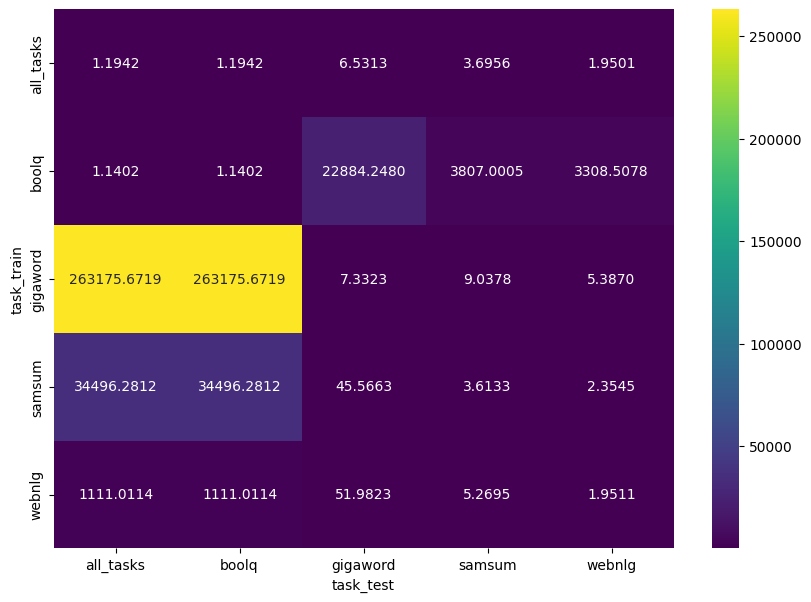

In [23]:
model = '1.7B-500'

tasks_train = ['summarization', 'classification', 'open_qa', 'all_tasks']
tasks_test =  ['summarization', 'classification', 'open_qa', 'all_tasks']

tasks_train = ['english', 'spanish', 'german', 'portuguese', 'swedish', 'all_languages']
tasks_test = ['english', 'spanish', 'german', 'portuguese', 'swedish', 'all_languages']

tasks_train = ['boolq', 'gigaword', 'samsum', 'webnlg', 'all_tasks']
tasks_test = ['boolq', 'gigaword', 'samsum', 'webnlg', 'all_tasks']

results_ds = pd.DataFrame()

for task_train in tasks_train:
    for task_test in tasks_test:
        
        path = f'inference_results/experiments/{task_train}_{task_test}/{model}/perplexity.json'

        with open(path, 'r') as f:
            results = json.load(f)
            results['task_train'] = task_train
            results['task_test'] = task_test
            results_df = pd.DataFrame([results]) 
            results_ds = pd.concat([results_ds, results_df], axis=0, ignore_index=True)

results_ds = results_ds.set_index(['task_train', 'task_test'])
results_ds = results_ds[['average_perplexity', 'median_perplexity']]
results_ds = results_ds.unstack()
results_ds = results_ds['median_perplexity']

plt.figure(figsize=(10, 7))
sns.heatmap(results_ds, annot=True, cmap='viridis', fmt=".4f")


<Axes: xlabel='task_test', ylabel='task_train'>

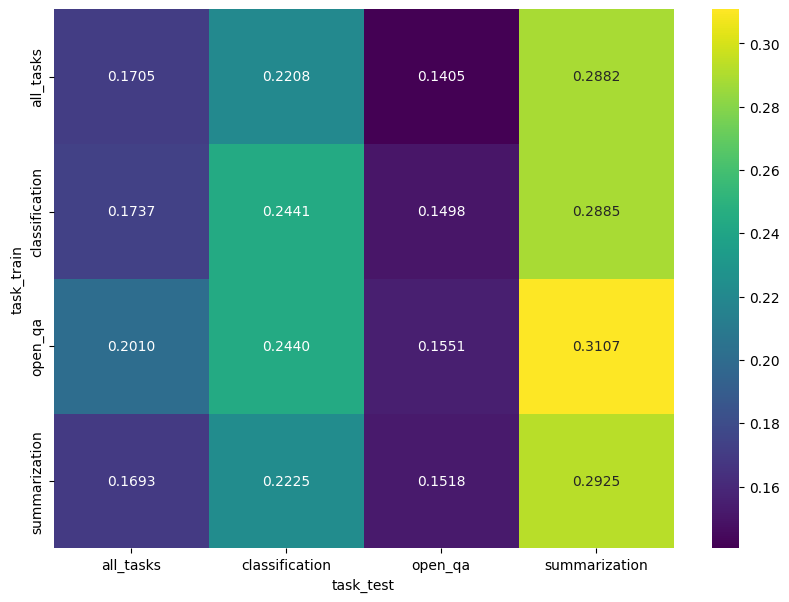

In [20]:
model = '1.7B'

tasks_train = ['summarization', 'classification', 'open_qa', 'all_tasks']
tasks_test =  ['summarization', 'classification', 'open_qa', 'all_tasks']

results_ds = pd.DataFrame()

for task_train in tasks_train:
    for task_test in tasks_test:
        path = f'inference_results/experiments/{task_train}_{task_test}/{model}/rouge.json'
        #read json
        with open(path, 'r') as f:
            results = json.load(f)
            results['task_train'] = task_train
            results['task_test'] = task_test
            results_df = pd.DataFrame([results]) 
            results_ds = pd.concat([results_ds, results_df], axis=0, ignore_index=True)

results_ds = results_ds.set_index(['task_train', 'task_test'])
results_ds = results_ds[['rouge1', 'rouge2', 'rougeL']]
results_ds = results_ds.unstack()
results_ds = results_ds['rouge1']

plt.figure(figsize=(10, 7))
sns.heatmap(results_ds, annot=True, cmap='viridis', fmt=".4f")


In [21]:
model = '1.7B'
model = '360M'

results_ds = pd.DataFrame()
tasks_train = ['summarization', 'classification', 'open_qa', 'all_tasks']
tasks_train = ['english', 'spanish', 'german', 'portuguese', 'swedish', 'all_languages']
#tasks_train = ['boolq', 'gigaword', 'samsum', 'webnlg', 'all_tasks']

for task_train in tasks_train:

    path = f'output_centralized/experiments_lora32/{task_train}/{model}/checkpoint-500/trainer_state.json'

    with open(path, 'r') as f:

        results = json.load(f)['log_history']
        results = pd.DataFrame(results)
        results['task_train'] = task_train
        results['eval_loss'] = results['eval_loss']
        results_ds = pd.concat([results_ds, results], axis=0, ignore_index=True)


FileNotFoundError: [Errno 2] No such file or directory: 'output_centralized/experiments_lora32/english/360M/checkpoint-500/trainer_state.json'

<Axes: xlabel='step', ylabel='loss'>

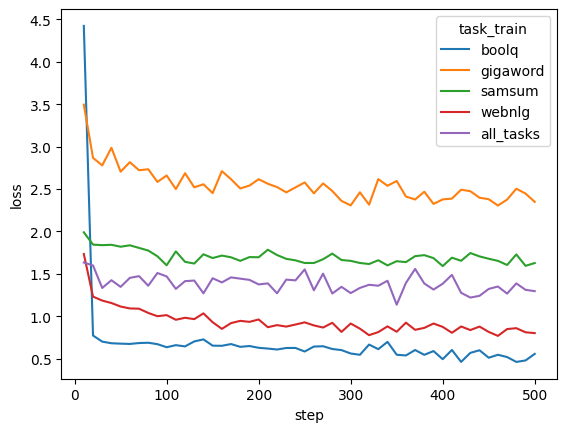

In [ ]:
results_ds = results_ds.set_index(['task_train', 'epoch'])
sns.lineplot(data=results_ds, x='step', y='loss', hue='task_train')

<Axes: xlabel='step', ylabel='eval_loss'>

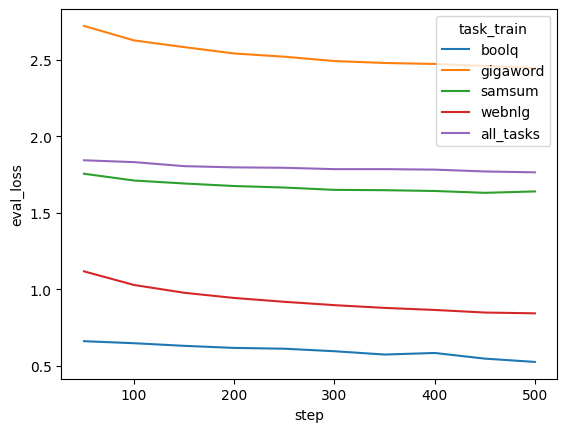

In [ ]:
results_eval = results_ds.reset_index()[['eval_loss', 'task_train', 'step']].dropna()
sns.lineplot(data=results_eval, x='step', y='eval_loss', hue='task_train')


<Axes: xlabel='step', ylabel='mean_token_accuracy'>

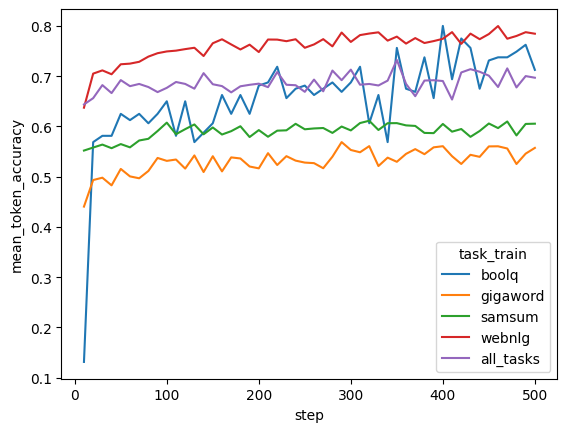

In [ ]:
sns.lineplot(data=results_ds, x='step', y='mean_token_accuracy', hue='task_train')

<Axes: xlabel='step', ylabel='eval_mean_token_accuracy'>

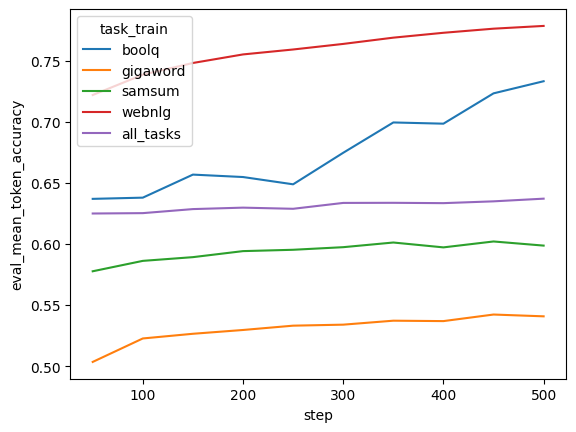

In [ ]:
results_eval = results_ds.reset_index()[['eval_loss','eval_mean_token_accuracy', 'task_train', 'step']].dropna()
sns.lineplot(data=results_eval, x='step', y='eval_mean_token_accuracy', hue='task_train')